In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo SPA5anos.csv
data = pd.read_csv('SPA5anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,SP1,18/08/17,Leganes,Alaves,H,2.05,3.20,4.10,2.05,3.10,...,3.50,2.03,3.25,4.52,2.05,3.2,4.40,2.05,3.10,4.00
1,SP1,18/08/17,Valencia,Las Palmas,H,1.75,3.80,4.50,1.75,3.90,...,4.80,1.78,4.01,4.83,1.80,4.0,4.60,1.80,3.75,4.20
2,SP1,19/08/17,Celta,Sociedad,A,2.38,3.25,3.20,2.40,3.30,...,2.85,2.44,3.40,3.16,2.40,3.4,3.13,2.40,3.40,2.90
3,SP1,19/08/17,Girona,Ath Madrid,D,8.00,4.33,1.45,7.50,4.33,...,1.45,8.36,4.38,1.49,7.50,4.3,1.50,8.00,4.20,1.44
4,SP1,19/08/17,Sevilla,Espanol,D,1.62,4.00,5.50,1.62,3.90,...,6.20,1.62,4.17,6.18,1.65,4.0,5.75,1.67,3.60,5.50


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,SP1,18/08/17,Leganes,Alaves,1,2.05,3.20,4.10,2.05,...,3.50,2.03,3.25,4.52,2.05,3.2,4.40,2.05,3.10,4.00
1,2,SP1,18/08/17,Valencia,Las Palmas,1,1.75,3.80,4.50,1.75,...,4.80,1.78,4.01,4.83,1.80,4.0,4.60,1.80,3.75,4.20
2,3,SP1,19/08/17,Celta,Sociedad,2,2.38,3.25,3.20,2.40,...,2.85,2.44,3.40,3.16,2.40,3.4,3.13,2.40,3.40,2.90
3,4,SP1,19/08/17,Girona,Ath Madrid,0,8.00,4.33,1.45,7.50,...,1.45,8.36,4.38,1.49,7.50,4.3,1.50,8.00,4.20,1.44
4,5,SP1,19/08/17,Sevilla,Espanol,0,1.62,4.00,5.50,1.62,...,6.20,1.62,4.17,6.18,1.65,4.0,5.75,1.67,3.60,5.50


Total de jogos:  1897
Total de colunas:  24
Total de jogos ganhos em casa:  842
Total de jogos ganhos pelo visitante:  534
Total de jogos empatados:  521
Percentual de jogos ganhos em casa: 44.39%


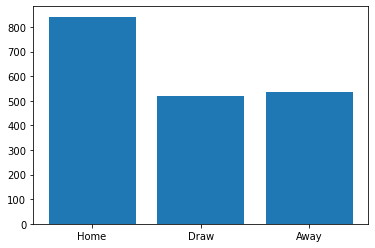

In [5]:
# Explorando a base de dados de dos campeonatos de 2017/2018 a 2021/2022 (últimas 5 temporadas completas)

# Obs.: 3 linhas da base de dados foram retiradas por falta de algumas informações necessárias de variáveis

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A   BWH   BWD   BWA   IWH  IWD   IWA   PSH   PSD   PSA  \
0   2.05   3.20   4.10  2.05  3.10  4.10  2.10  3.4  3.50  2.03  3.25  4.52   
1   1.75   3.80   4.50  1.75  3.90  4.60  1.75  3.6  4.80  1.78  4.01  4.83   
2   2.38   3.25   3.20  2.40  3.30  3.00  2.50  3.3  2.85  2.44  3.40  3.16   
3   8.00   4.33   1.45  7.50  4.33  1.45  7.20  4.4  1.45  8.36  4.38  1.49   
4   1.62   4.00   5.50  1.62  3.90  5.75  1.55  4.0  6.20  1.62  4.17  6.18   

    VCH  VCD   VCA   WHH   WHD   WHA  
0  2.05  3.2  4.40  2.05  3.10  4.00  
1  1.80  4.0  4.60  1.80  3.75  4.20  
2  2.40  3.4  3.13  2.40  3.40  2.90  
3  7.50  4.3  1.50  8.00  4.20  1.44  
4  1.65  4.0  5.75  1.67  3.60  5.50  
Labels
0    1
1    1
2    2
3    0
4    0
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (1897, 18)
[[0.06269592 0.03673469 0.08952497 ... 0.06269592 0.048      0.08675799]
 [0.04388715 0.08571429 0.10170524 ... 0.04702194 0.1        0.09284627]
 [0.08338558 0.04081633 0.06211937 ... 0.0846395  0.072      0.05327245]
 ...
 [0.06583072 0.10204082 0.05602923 ... 0.06269592 0.112      0.06240487]
 [0.09090909 0.04489796 0.05207065 ... 0.08777429 0.06       0.05327245]
 [0.0984326  0.04489796 0.04689403 ... 0.0984326  0.056      0.04718417]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:1520]     representa 80% dos dados
# Teste [1520:1710]      representa 10% dos dados
# Previsão [1710:1900]     representa 10% dos dados


X_train = features_scale[:1520]
X_test = features_scale[1520:1710]
y_train = labels[:1520]
y_test = labels[1520:1710]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1520 1520
190 190


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 47.89%
F1 Score: 47.89%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 47.89%
F1 Score: 47.89%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 44.74%
F1 Score: 43.38%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 38.42%
F1 Score: 38.42%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[1710:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[1710:]

res_full = data['FTR']
res_prev = res_full[1710:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
1710     0         2     1711
1711     1         1     1712
1712     0         1     1713
1713     1         1     1714
1714     0         2     1715
...    ...       ...      ...
1892     0         1     1893
1893     2         2     1894
1894     2         1     1895
1895     1         1     1896
1896     2         1     1897

[187 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

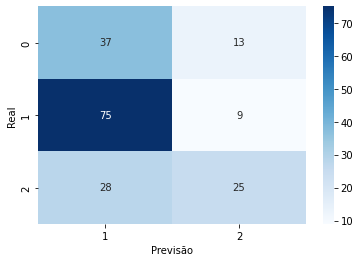

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')